In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold

%matplotlib inline

In [2]:
train = pd.concat([pd.read_csv('X.train.csv'), pd.read_csv('y.train.csv')], axis=1)
test = pd.read_csv('X.test.csv')
meta = pd.read_csv('MetaData.csv')

In [3]:
train.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331,label
0,826.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,NaN,0.0,0.5,0
1,15.0,0.0,0,0.0,0.0,0.0,0.0,0.030303,0.083333,0.0,...,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0
2,242.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,1.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.5,0
3,1038.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0
4,971.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0


In [4]:
test.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,685.0,0.0,0,0.0,0.0,0.0,0.0,0.010101,0.097222,0.0,...,0.5,0.5,0.5,0.0,0.5,0.5,0.5,0.0,0.0,0.0
1,1150.0,0.0,0,0.0,0.0,0.0,0.0,0.010101,0.083333,0.0,...,0.5,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.5
2,91.0,0.0,1,0.0,0.0,0.0,1.0,0.010101,0.097222,0.0,...,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,332.0,0.0,1,0.0,0.0,0.0,1.0,NaN,NaN,0.0,...,0.5,0.5,0.5,0.0,0.5,0.0,0.0,NaN,0.0,0.0
4,714.0,0.0,1,0.0,0.0,1.0,1.0,NaN,NaN,NaN,...,0.5,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


In [5]:
meta.head()

,varnum,type,Column Type
0,V2,char,Numeric
1,V3,num,Category
2,V4,num,Category
3,V5,num,Category
4,V6,num,Category


In [6]:
num = meta[meta['Column Type'] == 'Numeric']['varnum'].tolist()
cat = meta[meta['Column Type'] == 'Category']['varnum'].tolist()
cats = []
for c in cat:
    v = test[c].value_counts().index.tolist()
    if len(v) == 2 and 0 in v and 1 in v:
        cats.append(c)

def leave_num(data):
    return data[num]

def leave_bool(data):  
    return data[num + cats]

In [7]:
def onehot_encode(train, test):
    first_n = train.shape[0]
    onehot = pd.get_dummies(pd.concat([train, test]), columns=cat)
    return onehot[:first_n], onehot[first_n:]

In [8]:
def save(clf, X_train, X_test):
    clf.fit(X_train, train.label)

    Y_test = pd.DataFrame()
    Y_test['Id'] = np.arange(X_test.shape[0])
    Y_test['Prediction'] = clf.predict_proba(X_test)[:, 1]

    Y_test.to_csv('res.csv', index=False)

In [9]:
X_train_imp, X_test_imp = train.drop('label', axis=1).fillna(-1), test.fillna(-1)
X_train_num, X_test_num = leave_num(X_train_imp), leave_num(X_test_imp)
X_train_bool, X_test_bool = leave_bool(X_train_imp), leave_bool(X_test_imp)
X_train_onehot, X_test_onehot = onehot_encode(X_train_imp, X_test_imp)

Сначала была предпринята попытка улучшить baseline решение - подбор параметров `min_samples_leaf` и `max_features`, а также выставление какого-то большого числа `n_estimators` для случайного леса. В результате запуска `GridSearchCV` были подобраны `min_samples_leaf=11, max_features=200`, количество деревьев было выставлено в `n_estimators=20000`. Были испробованы разные методы заполнения пропусков - `most_frequent, fillna(0), fillna(-1)`, в результате последний показал наилучшее качество. Кажется, это произошло из-за того, что часто в данных образуются пропуски из-за каких-то специфических причин и лучше это явно обозначать (в данном случае поставив в значение признака `-1`).

In [ ]:
param_grid = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'max_features': [50, 100, 200, 'sqrt', 'log2']
}
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, criterion='entropy')
optimizer = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=5)
optimizer.fit(X_train_imp, train.label)
optimizer.best_estimator_, optimizer.best_score_

In [11]:
clf = RandomForestClassifier(n_estimators=20000, n_jobs=-1, random_state=42,
                             min_samples_leaf=11, max_features=200)

In [12]:
-np.mean(cross_val_score(clf, X_train_imp, train.label, scoring='neg_log_loss', cv=5))

0.21952912240018216

In [13]:
save(clf, X_train_imp, X_test_imp)

Далее был произведен еще один подбор параметров (в `max_features` добавлены бОльшие значения, а также попробован энтропийный критерий вместо критерия джини). В результате были подобраны параметры `min_samples_leaf=7, max_features=400`. Ошибка оказалась меньше, чем в предыдущей попытке, поэтому в дальнейшем использовался `criterion='entropy'`.

In [15]:
param_grid = {
    'min_samples_leaf': [2, 3, 5, 7, 9, 11, 12],
    'max_features': [200, 300, 400, 'sqrt', 'log2']
}
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, criterion='entropy')
optimizer = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=5)
optimizer.fit(X_train_imp, train.label)
optimizer.best_estimator_, optimizer.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=None, max_features=400, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=7, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 -0.21660566063133974)

In [16]:
clf = RandomForestClassifier(n_estimators=20000, n_jobs=-1, random_state=42,
                             min_samples_leaf=7, max_features=400, criterion='entropy')

In [17]:
-np.mean(cross_val_score(clf, X_train_imp, train.label, scoring='neg_log_loss', cv=5))

0.21714792455484938

In [18]:
save(clf, X_train_imp, X_test_imp)

---

Далее был произведен One-hot encoding, после чего была попытка обучить на этих данных логистическую регрессию, а также случайный лес и сравнить с предыдущими результатами. Видно, что результат получился хуже как для логистической регрессии, так и для случайного леса.

In [22]:
param_grid = {'C': [0.01, 0.13, 0.14, 0.15,0.16, 0.5]}
clf = LogisticRegression(penalty='l1', random_state=42)
optimizer = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)
optimizer.fit(X_train_onehot, train.label)
optimizer.best_estimator_, optimizer.best_score_

(LogisticRegression(C=0.13, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False), -0.2271032613027047)

In [23]:
param_grid = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': [50, 100, 'sqrt', 'log2']
}
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
optimizer = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=5)
optimizer.fit(X_train_onehot, train.label)
optimizer.best_estimator_, optimizer.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features=100, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=7, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 -0.22095191148333732)

In [ ]:
clf = RandomForestClassifier(n_estimators=500, max_features=100, random_state=42,
                             min_samples_leaf=10, n_jobs=-1)
save(clf, X_train_onehot, X_test_onehot)

Далее для логистической регрессии произведена попытка обучиться только на числовых данных и на категориальных данных, у которых только 2 категории (0 и 1) [назовем их булевыми]. Видно, что ошибка при обучении только на числовых данных больше, чем при обучении на числовых и булевых, поэтому в дальнейшем использовалась логистическая регрессия на числовых и булевых признаках.

In [24]:
param_grid = {'C': [0.43, 0.45, 0.47, 0.5, 0.55]}
clf = LogisticRegression(penalty='l1', random_state=42)
optimizer = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)
optimizer.fit(X_train_num, train.label)
optimizer.best_estimator_, optimizer.best_score_

(LogisticRegression(C=0.43, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False), -0.22472507144967466)

In [25]:
param_grid = {'C': [0.196, 0.197, 0.199, 0.22]}
clf = LogisticRegression(penalty='l1', random_state=42)
optimizer = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)
optimizer.fit(X_train_bool, train.label)
optimizer.best_estimator_, optimizer.best_score_

(LogisticRegression(C=0.197, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False), -0.2226198537009394)

In [26]:
clf = LogisticRegression(penalty='l1', random_state=42, C=0.199)
save(clf, X_train_bool, X_test_bool)

Также было проверено предположение, что ошибка может уменьшиться при балансировке данных (не уменьшилась).

In [27]:
param_grid = {'C': [0.196, 0.197, 0.199, 0.27, 0.3, 0.33, 0.5, 1]}
clf = LogisticRegression(penalty='l1', random_state=42, class_weight='balanced')
optimizer = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)
optimizer.fit(X_train_bool, train.label)
optimizer.best_estimator_, optimizer.best_score_

(LogisticRegression(C=0.27, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 -0.46652655986918351)

---

Далее из лабы был позаимствован `BlendingClassifier` с небольшими изменениями: так как ранее мы показали, что LogisticRegression и RandomForest показывают наилучшие результаты на разных данных, в конструктор были добавлены параметры `clf1_preprocess`, `clf2_preprocess` - функции, которые преобразуют исходные фичи в фичи, нужные конкретному классификатору. По умолчанию, если ничего не передать, эти функции ничего не делают с `X`.

In [30]:
class BlendingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf1, clf2, clf1_preprocess=lambda x: x, clf2_preprocess=lambda x: x, alpha=0.5):
        self.clf1 = clf1
        self.clf2 = clf2
        self.clf1_preprocess = clf1_preprocess
        self.clf2_preprocess = clf2_preprocess
        self.alpha = alpha
    
    def fit(self, X, y):
        self.clf1.fit(self.clf1_preprocess(X), y)
        self.clf2.fit(self.clf2_preprocess(X), y)
        return self
    
    def predict(self, X):
        clf1_pred = self.clf1.predict(self.clf1_preprocess(X))
        clf2_pred = self.clf2.predict(self.clf2_preprocess(X))
        return clf1_pred*self.alpha + clf2_pred*(1 - self.alpha)
    
    def predict_proba(self, X):
        clf1_pred_proba = self.clf1.predict_proba(self.clf1_preprocess(X))
        clf2_pred_proba = self.clf2.predict_proba(self.clf2_preprocess(X))
        return clf1_pred_proba*self.alpha + clf2_pred_proba*(1 - self.alpha)

In [31]:
def plot_params_score(alphas, scores):
    means = np.zeros(len(scores))
    stds = np.zeros(len(scores))
    for i, score in enumerate(scores):
        means[i] = np.mean(score)
        stds[i] = np.std(score)

    plt.errorbar(range(len(scores)), means, xerr=0.5, yerr=2*stds, linestyle='', fmt='o')
    plt.xticks(range(len(scores)), alphas, rotation='vertical')
    plt.xlabel('alpha')
    plt.ylabel('score')
    plt.show()

In [ ]:
param_grid = {'C': [0.196, 0.197, 0.199, 0.27, 0.3, 0.33, 0.5, 1]}
clf = LogisticRegression(penalty='l1', random_state=42)
optimizer = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)
optimizer.fit(X_train_bool, train.label)
optimizer.best_estimator_, optimizer.best_score_

alpha: 0.1, score: -0.22089369758867633
alpha: 0.2, score: -0.21947181709087077
alpha: 0.30000000000000004, score: -0.21833591945853176
alpha: 0.4, score: -0.21745182582475814
alpha: 0.5, score: -0.21679951089684288
alpha: 0.6000000000000001, score: -0.2163684807066911
alpha: 0.7000000000000001, score: -0.21615612269957074
alpha: 0.8, score: -0.21616799515539106
alpha: 0.9, score: -0.21642051523865763


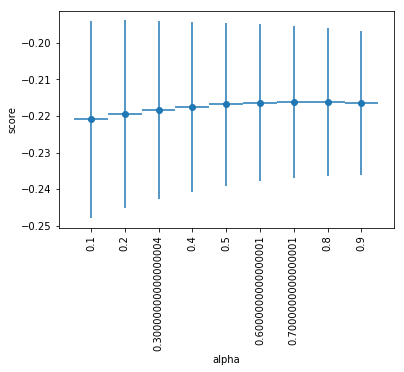

In [33]:
clf1 = RandomForestClassifier(n_estimators=1000, min_samples_leaf=2, max_features=200,
                              criterion='entropy', random_state=42, n_jobs=-1)
clf2 = LogisticRegression(penalty='l1', random_state=42, C=0.2)
alphas = list(map(lambda i: i*0.1, range(1, 10)))
scores = [0]*len(alphas)
for i, alpha in enumerate(alphas):
    blending = BlendingClassifier(clf1, clf2, clf2_preprocess=leave_bool, alpha=alpha)
    scores[i] = cross_val_score(blending, X_train_imp, train.label, cv=5, scoring='neg_log_loss')
    print(f'alpha: {alpha}, score: {scores[i].mean()}')
plot_params_score(alphas, scores)

In [34]:
clf1 = RandomForestClassifier(n_estimators=10000, min_samples_leaf=2, max_features=200,
                              criterion='entropy', random_state=42, n_jobs=-1)
clf2 = LogisticRegression(penalty='l1', random_state=42, C=0.2)
clf = BlendingClassifier(clf1, clf2, clf2_preprocess=leave_bool, alpha=0.8)
save(clf, X_train_imp, X_test_imp)

В итоге с помощью такого блендинга с `alpha=0.8` удалось добиться

`Public Score: 0.23006`,

`Private Score: 0.21227`.

---

После пары про PCA был испробован этот метод - теперь логистическая регрессия на числовых и булевых признаках в блендинге заменена на логрег на n признаках после PCA.

In [35]:
n = 30
pca = PCA(n_components=n, random_state=1)
pca.fit(X_train_onehot)
tr = pca.transform(X_train_onehot)
tr = pd.DataFrame(tr, columns=list(map(lambda i: f'pca_{i}', range(n))))
tr.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29
0,397.223524,9.202526,-2.189962,4.549270,-2.860389,-0.661128,-1.127714,-1.576609,2.435424,-0.214111,...,0.725411,-1.880986,-1.253019,2.886256,-0.980574,2.297412,1.228414,-0.378631,-0.605802,0.823404
1,-413.796002,-2.642708,-1.816578,3.667889,-3.706980,-2.615337,2.154200,0.870472,-1.079709,-1.906726,...,-1.719804,1.113808,-1.419744,0.418493,0.472745,-1.704450,1.735314,0.174928,-0.530689,0.675752
2,-186.792513,-4.251938,-4.995192,4.231895,2.960767,1.232992,-1.997857,-2.006408,-1.497303,1.266953,...,1.144931,0.094340,-0.533998,-0.873726,-1.637557,0.221892,-0.282241,0.688962,1.135661,1.948798
3,609.182722,-3.988165,0.875283,-6.216485,2.647138,-0.395348,2.577097,-1.594666,1.456206,-1.572396,...,2.252659,-1.107131,-1.518347,-1.274131,0.044414,0.670109,0.130090,2.876533,-0.455379,-1.370996
4,542.184498,-3.108270,1.562811,-5.742595,-0.700203,-0.212724,2.938653,2.474078,4.090147,-0.824463,...,-1.404799,1.965380,-1.486253,-1.266973,-2.139169,-0.847958,-0.288191,1.387620,-0.873406,-1.634543


Одна компонента объясняет 99% дисперсии - очень странный результат.

In [36]:
s = 0
for i, e in enumerate(sorted(pca.explained_variance_ratio_, key=lambda x: -x)):
    s += e
    if s >= 0.9:
        print(i + 1)
        break
print(s)

1
0.995802922398


In [37]:
param_grid = {'C': [0.01, 0.04,0.045, 0.05,0.055, 0.057, 0.07, 0.09, 0.1, 0.12, 0.2, 0.3, 0.33, 0.5, 1]}
clf = LogisticRegression(penalty='l1', random_state=42)
optimizer = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)
optimizer.fit(tr, train.label)
optimizer.best_estimator_, optimizer.best_score_

(LogisticRegression(C=0.055, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False), -0.22288462741954426)

In [38]:
# После нескольких запусков PCA с различными n_components, было выбрано значение 30
# pca(10), C=0.1:  -0.22436733959923694
# pca(40), C=0.05: -0.22347890884850466
# pca(30), C=0.05: -0.22277993871800517

In [39]:
param_grid = {
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': [10, 'sqrt', 'log2']
}
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
optimizer = GridSearchCV(clf, param_grid, scoring='neg_log_loss', cv=5)
optimizer.fit(tr, train.label)
optimizer.best_estimator_, optimizer.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=8, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 -0.22985487329132009)

Видно, что блендинг на преобразованных данных оказался хуже, чем предыдущий.

alpha: 0.1, score: -0.22279529010960158
alpha: 0.2, score: -0.22263431955972193
alpha: 0.30000000000000004, score: -0.22274067935721537
alpha: 0.4, score: -0.22307952358295272
alpha: 0.5, score: -0.22363349410469527
alpha: 0.6000000000000001, score: -0.22439522782036905
alpha: 0.7000000000000001, score: -0.22536469329770323
alpha: 0.8, score: -0.22654854755415524
alpha: 0.9, score: -0.22796087570816023


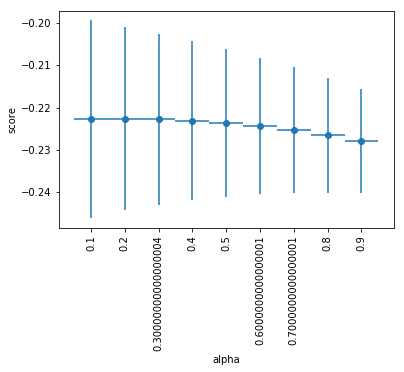

In [40]:
clf1 = RandomForestClassifier(n_estimators=20000, min_samples_leaf=10, max_features='sqrt',
                              criterion='entropy', random_state=42, n_jobs=-1)
clf2 = LogisticRegression(penalty='l1', random_state=42, C=0.1)
alphas = list(map(lambda i: i*0.1, range(1, 10)))
scores = [0]*len(alphas)
for i, alpha in enumerate(alphas):
    blending = BlendingClassifier(clf1, clf2, alpha=alpha)
    scores[i] = cross_val_score(blending, tr, train.label, cv=5, scoring='neg_log_loss')
    print(f'alpha: {alpha}, score: {scores[i].mean()}')
plot_params_score(alphas, scores)

Поэтому нужно взять RandomForest на изначальных признаках и LogisticRegression на преобразованных. Однако, `BlendingClassifier` не получится запустить, так как в него не получится просунуть преобразование one hot encoding - придется все делать руками.

In [49]:
clf1 = RandomForestClassifier(n_estimators=2000, min_samples_leaf=2, max_features=200,
                              criterion='entropy', random_state=42, n_jobs=-1)
clf2 = LogisticRegression(penalty='l1', random_state=42, C=0.05)

alpha=0.1, loss=0.22122174744406617
alpha=0.2, loss=0.2198384419342377
alpha=0.30000000000000004, loss=0.218693058784504
alpha=0.4, loss=0.2177634670632198
alpha=0.5, loss=0.21703738042267884
alpha=0.6000000000000001, loss=0.2165096871230403
alpha=0.7000000000000001, loss=0.21618171763144206
alpha=0.8, loss=0.2160621610721626
alpha=0.9, loss=0.2161710321906233


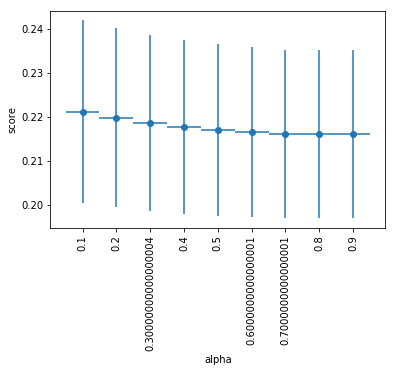

In [50]:
alphas = list(map(lambda i: i*0.1, range(1, 10)))
scores = [0]*len(alphas)
for i, alpha in enumerate(alphas):
    skf = StratifiedKFold(n_splits=5, random_state=42)
    losses = []
    for train_index, test_index in skf.split(X_train_imp, train.label):
        clf1.fit(X_train_imp.iloc[train_index], train.label[train_index])
        pred1 = clf1.predict_proba(X_train_imp.iloc[test_index])
        clf2.fit(tr.iloc[train_index], train.label[train_index])
        pred2 = clf2.predict_proba(tr.iloc[test_index])
        pred = pred1*alpha + pred2*(1 - alpha)
        losses.append(log_loss(train.label[test_index], pred))
    print(f'alpha={alpha}, loss={np.mean(losses)}')
    scores[i] = losses
plot_params_score(alphas, scores)

alpha=0.75, loss=0.21609498533213375
alpha=0.78, loss=0.2160686627857591
alpha=0.8, loss=0.2160621610721626
alpha=0.82, loss=0.2160647274736359
alpha=0.85, loss=0.21608610358087693


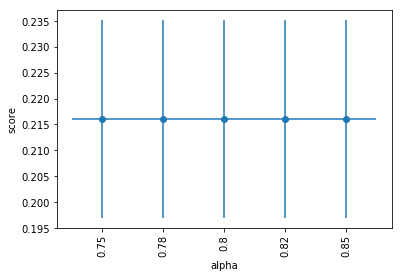

In [51]:
alphas = [0.75, 0.78, 0.8, 0.82, 0.85]
scores = [0]*len(alphas)
for i, alpha in enumerate(alphas):
    skf = StratifiedKFold(n_splits=5, random_state=42)
    losses = []
    for train_index, test_index in skf.split(X_train_imp, train.label):
        clf1.fit(X_train_imp.iloc[train_index], train.label[train_index])
        pred1 = clf1.predict_proba(X_train_imp.iloc[test_index])
        clf2.fit(tr.iloc[train_index], train.label[train_index])
        pred2 = clf2.predict_proba(tr.iloc[test_index])
        pred = pred1*alpha + pred2*(1 - alpha)
        losses.append(log_loss(train.label[test_index], pred))
    print(f'alpha={alpha}, loss={np.mean(losses)}')
    scores[i] = losses
plot_params_score(alphas, scores)

Видно, что оценка получилась лучше, чем при блендинге с логистической регрессией, обученной на числовых и булевых признаках, однако, Public Score оказался хуже.

In [44]:
clf1 = RandomForestClassifier(n_estimators=50000, min_samples_leaf=3, max_features=300,
                              criterion='entropy', random_state=42, n_jobs=-1)
clf2 = LogisticRegression(penalty='l1', random_state=42, C=0.05)
clf1.fit(X_train_imp, train.label)
clf2.fit(tr, train.label)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
tr_test = pca.transform(X_test_onehot)

In [46]:
alpha = 0.8
pred1 = clf1.predict_proba(X_test_imp)
pred2 = clf2.predict_proba(tr_test)
pred = pred1*alpha + pred2*(1 - alpha)

In [47]:
Y_test = pd.DataFrame()
Y_test['Id'] = np.arange(X_test_imp.shape[0])
Y_test['Prediction'] = pred[:, 1]

Y_test.to_csv('res1.csv', index=False)

В итоге с помощью такого блендинга с `alpha=0.8` удалось добиться

`Public Score: 0.23048`,

`Private Score: 0.21220`.